#### make sure dataset is downloaded and extracted `@repoDirectory/data/raw/font-dataset` -> this path should be at the repo root
<mark> make sure that these <mark>

In [1]:
#install all dependencies
%pip install -r "../../requirements.txt"


### importing libraries

```python

In [2]:
import skimage as ski 
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks # to detect the orientation of the text in image 
from skimage.feature import canny
import matplotlib.pyplot as plt 
from scipy import stats



In [3]:
#from the tutorial
def plot_change(img_before, img_after, effect):
    """
    Plots the original image and the image after applying a specific effect.

    Parameters:
    - img_before (numpy.ndarray): The original image.
    - img_after (numpy.ndarray): The image after applying the effect.
    - effect (str): The effect applied to the image.

    Returns:
    None
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
    ax = axes.ravel()
    ax[0].imshow(img_before, cmap=plt.cm.gray if effect in ["Threshold", "Edge"] else "jet")
    ax[0].set_title("Original")
    ax[1].imshow(img_after, cmap=plt.cm.gray if effect in ["Grayscale", "Threshold", "Edge"]  else "jet")
    ax[1].set_title(effect)
    fig.tight_layout()
    plt.show()

### 1- fixing text orientation as much as possible 

* based on this <a href="https://medium.com/wearesinch/correcting-image-rotation-with-hough-transform-e902a22ad988">article <a>

In [4]:
# Function to detect the orientation of the text in image


def hough_transforms(image):
	
	filtered_img = ski.filters.median(image)  # Apply median filter to remove noise
	
	gray = ski.color.rgb2gray(filtered_img)  # Convert image to grayscale
	
	guess = cv2.GaussianBlur(gray, (11, 11), 0)  # Apply Gaussian blur
	
	thresh = ski.filters.threshold_otsu(guess)  # Apply Otsu's thresholding
	
	binary = gray > thresh  # Convert image to binary
	
	edges = canny(binary)  # Detect edges using Canny edge detection
	
	h, theta, d = hough_line(edges)  # Perform Hough line transform
	
	accum, angles, dists = hough_line_peaks(h, theta, d)  # Find peaks in Hough space
	
	angles = np.rad2deg(angles)  # Convert angles to degrees
	
	angle_mode = stats.mode(angles)  # Find the most common angle
	
	rotation_angle = angle_mode.mode  # Get the rotation angle
	
	# i am not sure if this will work with all images  
	if rotation_angle < 0:
		rotation_angle = 90 + rotation_angle  # Adjust rotation angle if negative
	else:
		rotation_angle = rotation_angle - 90  # Adjust rotation angle if positive
	
	return rotation_angle
def hough_transforms_with_plotting_stages(image): # same as above function but with plotting the stages of the process
	# Create a figure and axes
	fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(25, 25))
	axes[0].imshow(image)
	axes[0].set_title('Original image') 

	# Apply median filter to the image
	filtered_img = ski.filters.median(image)
	axes[1].imshow(filtered_img)
	axes[1].set_title('Median Filter')

	# Convert the filtered image to grayscale
	gray = ski.color.rgb2gray(filtered_img)        
	axes[2].imshow(gray , cmap='gray')
	axes[2].set_title('Gray image')

	# Apply Gaussian blur to the grayscale image
	guess = cv2.GaussianBlur(gray,(11,11),0)
	axes[3].imshow(guess, cmap='gray')    
	axes[3].set_title('Gaussian Blur')

	# Apply Otsu's thresholding to obtain a binary image
	thresh = ski.filters.threshold_otsu(guess)
	binary = gray > thresh
	axes[4].imshow(binary , cmap='gray')
	axes[4].set_title('Binary image')

	# Apply Canny edge detection to the binary image
	edges = canny(binary)
	axes[5].imshow(edges,cmap='gray')
	axes[5].set_title('Edges')

	plt.tight_layout()
	plt.show()

	# Perform Hough line detection on the edges
	h, theta, d = hough_line(edges)
	accum, angles, dists = hough_line_peaks(h, theta, d)
	angles = np.rad2deg(angles)
	angle_mode = stats.mode(angles)
	rotation_angle = angle_mode.mode

	# Adjust the rotation angle to be within the range of -90 to 90 degrees
	if rotation_angle < 0:
		rotation_angle = 90 + rotation_angle
	else:
		rotation_angle = rotation_angle - 90

	return rotation_angle

def rotate_image(rotation_angle , image ) :
    center = (image.shape[1] // 2, image.shape[0] // 2)
    scale = 1.0 # zoom in or out 
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2])
    return rotated_image


### test rotation on sample image 

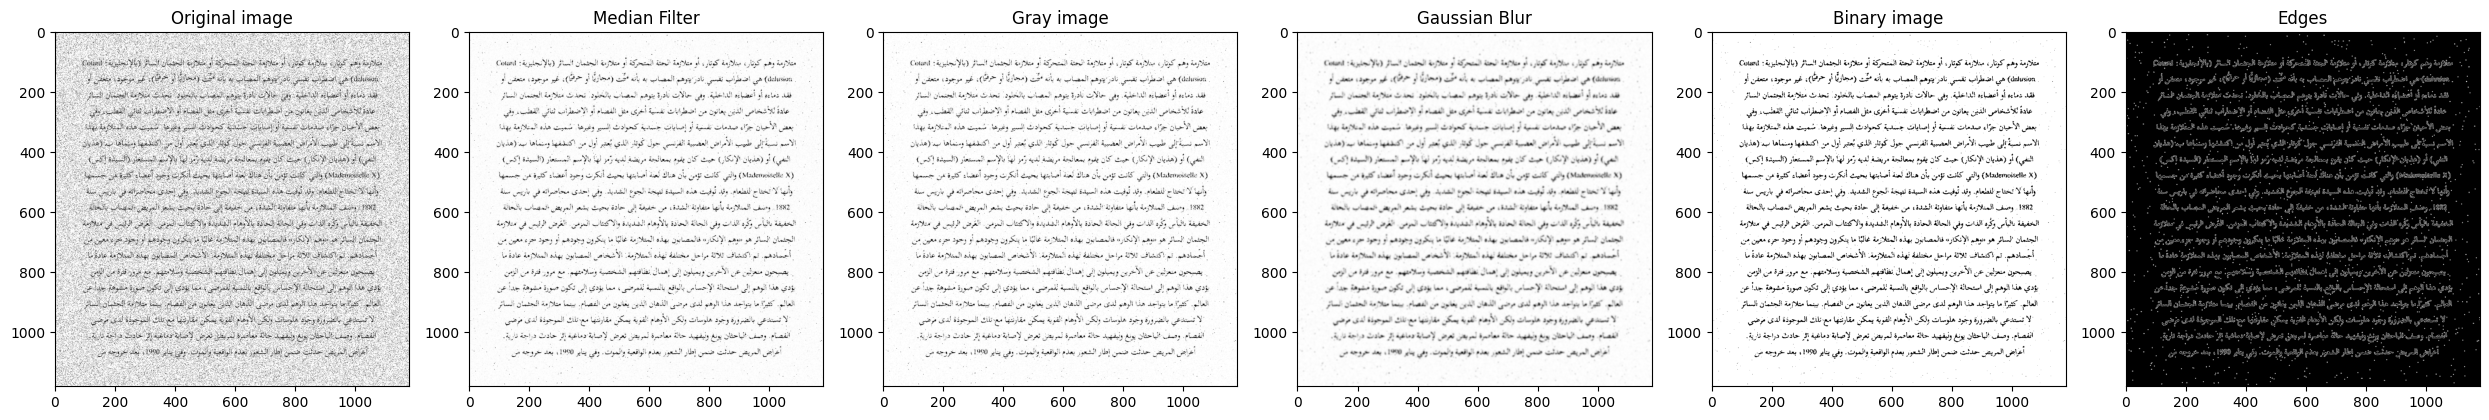

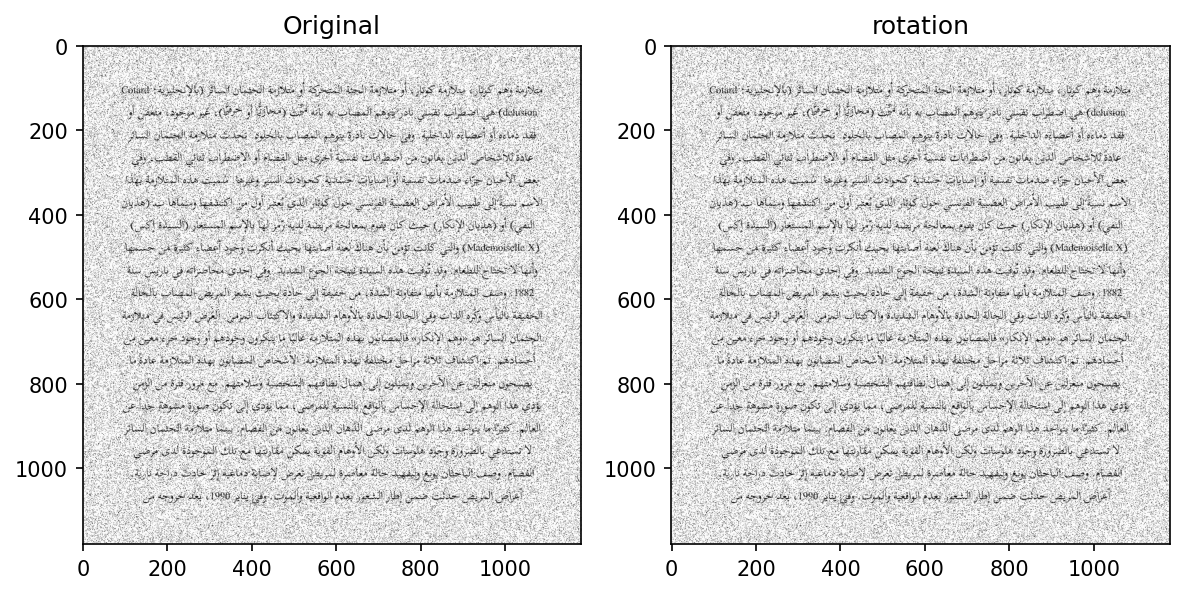

In [5]:
testimg= ski.io.imread("../../data/raw/fonts-dataset/Scheherazade New/924.jpeg")
rotation_angle  = hough_transforms_with_plotting_stages(testimg)
newimg = rotate_image(rotation_angle, testimg)
plot_change(testimg , newimg , effect="rotation")

## -1 - Draw box on lines

In [6]:
import cv2
import numpy as np

# Load image
img = cv2.imread("../data/processed/fonts-dataset/Marhey/58.jpeg")

# Display image
# cv2.imshow("Original Image", img)

# Reduce noise
denoised_img = cv2.pyrMeanShiftFiltering(img, sp=10, sr=130)

# Display denoised image
# cv2.imshow("Denoised Image", denoised_img)

# Convert to grayscale
gray = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY)

# Display grayscale image
# cv2.imshow("Grayscale Image", gray)

# Threshold the image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Dilation to connect nearby words
kernel = np.ones((5,100), np.uint8)  # Adjust kernel size as needed
dilated = cv2.dilate(binary, kernel, iterations=5)

# Find contours (potential text lines)
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on size and shape (adapt filtering based on your data)
text_lines = []
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
  aspect_ratio = float(w) / h
  if aspect_ratio > 5 and cv2.contourArea(cnt) > 1000:  # Adjust thresholds as needed
    text_lines.append((x, y, w, h))

# Draw bounding boxes around detected text lines
for x, y, w, h in text_lines:
  # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
  continue

# Display image with detected lines
cv2.imshow("Text Lines", img)
cv2.waitKey(0)


### 2- Binarization

In [7]:
def Binarize(image):
    """
    Binarizes an image using Otsu's thresholding method.

    Parameters:
    - image (numpy.ndarray): The image to binarize.

    Returns:
    - numpy.ndarray: The binarized image.
    """
    filtered_img = ski.filters.median(image)
    # guess = cv2.GaussianBlur(filtered_img,(11,11),0)
    sharp = ski.filters.unsharp_mask(filtered_img, radius=1, amount=1)
    
    gray = ski.color.rgb2gray(sharp)
    thresh = ski.filters.threshold_otsu(gray)
    binary = gray > thresh
    # Check the color of the first pixel if its white 
    if binary[0, 0]:
        binary = ~binary  # Invert the binarization
    
    
    return binary


### Apply step 1 and 2 on all images and save 

In [25]:
# read image 
folder_name = ["IBM Plex Sans Arabic" ,"Lemonada" , "Marhey" , "Scheherazade New" ]
testimg= ski.io.imread("../data/raw/fonts-dataset/Scheherazade New/924.jpeg")

for j in range(0 , 4 ) : 
    for i in range(0, 1000): 
        img = ski.io.imread("../data/raw/fonts-dataset/"+folder_name[j]+"/"+str(i)+".jpeg")
        rotation_angle  = hough_transforms(img)
        binarized_image = Binarize(img)
        binarized_image = binarized_image.astype(np.uint8) * 255
        rotated_image = rotate_image(rotation_angle, binarized_image)
        ski.io.imsave("../data/processed/fonts-dataset/"+folder_name[j]+"/"+str(i)+".jpeg", binarized_image)


